# Seasonal Decomposition
Seasonal Decomposition is the breakdown of a time series graph into its individual components.
- Seasonality
- Irregularities
- Trends
- Cyclical
- Error

The goal of this chapter is to break down the number of cars sold within Maryland.

### Import Packages

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.gridspec as gridspec
from pmdarima import auto_arima
from itertools import product
import warnings

In [3]:
from sklearn.metrics import mean_absolute_error

### Import Functions

#### Plotting Data

In [4]:
import matplotlib.pyplot as plt

def plot_multiple_series(xvalue, yvalues, labels, title, xlabel, ylabel, alpha=None):
    plt.figure(figsize=(14,8))
    for i in range(len(labels)):
        if alpha is not None:
            plt.plot(xvalue, yvalues[i], label=labels[i], alpha=alpha[i])
        else:
            plt.plot(xvalue, yvalues[i], label=labels[i])
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

In [5]:
#Create a function for line time series
def line_series(x,y,title,xlabel,ylabel,grid=False):
    plt.figure(figsize=(12,8))
    plt.plot(x,y)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(grid)
    plt.show()


In [6]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_with_annotated_dates(xvalues, yvalues, events_list, date_of_events_list, xlabel, ylabel, title, line_colors=None):
    plt.figure(figsize=(12, 8))
    plt.plot(xvalues, yvalues, label='Monthly Cars Sold')
    
    # Convert date_of_events_list to datetime
    date_of_events_list = pd.to_datetime(date_of_events_list)
    
    # Default colors if line_colors is not provided
    if line_colors is None:
        line_colors = ['orange', 'red', 'green', 'blue', 'purple', 'brown', 'pink']
    
    for i, (event, date) in enumerate(zip(events_list, date_of_events_list)):
        color = line_colors[i % len(line_colors)]
        plt.axvline(x=date, color=color, linestyle='--', label=event)
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

In [7]:
# create a function for a least squares line

# import the neccessary packages
from sklearn.linear_model import LinearRegression

def least_squares_line(incrementing_value,y_value,title,xlabel,ylabel):
    plt.figure(figsize=(12,8))

    #Create the x and y values for the least squares lines
    x_trend_least_squares = incrementing_value.values.reshape(-1,1).astype(float)
    y_trend_least_squares = y_value.astype(float) 

    #Train the model using linear regression packagage
    model = LinearRegression()

    #Fit the model to the x and y values
    model.fit(x_trend_least_squares,y_trend_least_squares)

    #Create the y values for the least squares
    y_pred = model.predict(x_trend_least_squares)

    plt.scatter(x_trend_least_squares, y_trend_least_squares, label='original data', color='blue')
    plt.plot(x_trend_least_squares, y_pred, label='least squares', color='red')

    plt.legend()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

    #Get the slope (coefficient) and intercept
    slope = model.coef_[0]
    intercept = model.intercept_

    return slope, intercept

In [8]:
# Custom function to plot histogram
def plot_histogram(ax, data, bins,title,xlabel,ylabel):
    ax.hist(data, bins=bins, edgecolor='black')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

#### Preprocess Data

In [9]:
#When dealing with monthly values it can be useful to split it up into months of the year with days within them
#Create list of months
months = ['January','February','March','April','May','June','July','August','September','October','November','December']

def create_monthly_data(df,value_column,incrementing_month):

    original_copy = df.copy()
    original_copy['Incrementing Month'] = range(0,len(original_copy))
    original_copy.set_index(incrementing_month,inplace=True)

    #Determine the number of years
    num_years = (len(df)+11) // 12

    #Create a new dataframe where the index is the number of years and the columns are the number of months
    monthly_data = pd.DataFrame(index=range(num_years),columns = months)

    #Fill the empty dataframe
    for i, row in original_copy.iterrows():
        year = (i) // 12
        month = months[(i) % 12]
        monthly_data.at[year,month] = row[value_column]

    return monthly_data

In [10]:
def convert_to_long_format(df,start_date):
    """
    Convert a wide-format DataFrame with months as columns to a long-format DataFrame with date and total columns.
    
    Parameters:
    df (pd.DataFrame): DataFrame where columns are months and rows are years.
    
    Returns:
    pd.DataFrame: Long-format DataFrame with date and total columns.
    """
    # Melt the DataFrame to long format
    long_df = df.reset_index().melt(id_vars='index', var_name='month', value_name='total')
    
    # Rename the 'index' column to 'Start Index'
    long_df.rename(columns={'index': 'start_index'}, inplace=True)
    
    # Create a mapping of month names to month numbers
    month_mapping = {month: i+1 for i, month in enumerate(df.columns)}
    
    # Map month names to month numbers
    long_df['month_number'] = long_df['month'].map(month_mapping)
    
    # Create a 'Date' column by combining 'Start Index' and 'Month Number'
    long_df['date'] = pd.to_datetime(long_df['month_number'].astype(str) + '/1/' + (long_df['start_index'] + start_date).astype(str), format='%m/%d/%Y')
    
    # Drop the 'Month' column and 'Month Number' as they are no longer needed
    long_df.drop(columns=['month', 'month_number','start_index'], inplace=True)
    
    return long_df

In [11]:
# create smoothed data

from scipy.signal import savgol_filter

def savgol_smooth(y, window_length, polyorder):
    return savgol_filter(y, window_length, polyorder)

#### Curve Fitting

In [12]:
from scipy.optimize import curve_fit

def fit_curve(function, x_data, y_data, initial_guess_params):
    """
    Fit a curve to the given data using the specified function.

    Parameters:
    - function: Callable, the model function to fit.
    - x_data: array-like, the independent variable data.
    - y_data: array-like, the dependent variable data.
    - initial_guess_params: array-like, initial guesses for the function parameters.

    Returns:
    - popt: list, the optimal values for the parameters.
    - pcov: 2D array, the estimated covariance of popt.
    """
    popt, pcov = curve_fit(function, x_data, y_data, p0=initial_guess_params)
    return popt.tolist(), pcov

#### ARIMA/SARIMA Modeling

In [13]:
warnings.filterwarnings("ignore", message="No frequency information was provided, so inferred frequency")
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

def evaluate_time_series_models(data, ar_orders, ma_orders, d_orders):
    results = []

    # Evaluate AR models
    for p in ar_orders:
        try:
            model = ARIMA(data, order=(p, 0, 0)).fit()
            results.append(('AR', (p, 0, 0), model.aic, model.bic))
        except Exception as e:
            continue

    # Evaluate MA models
    for q in ma_orders:
        try:
            model = ARIMA(data, order=(0, 0, q)).fit()
            results.append(('MA', (0, 0, q), model.aic, model.bic))
        except Exception as e:
            continue

    # Evaluate ARMA models
    for p, q in product(ar_orders, ma_orders):
        try:
            model = ARIMA(data, order=(p, 0, q)).fit()
            results.append(('ARMA', (p, 0, q), model.aic, model.bic))
        except Exception as e:
            continue

    # Evaluate ARIMA models
    for p, d, q in product(ar_orders, d_orders, ma_orders):
        try:
            model = ARIMA(data, order=(p, d, q)).fit()
            results.append(('ARIMA', (p, d, q), model.aic, model.bic))
        except Exception as e:
            continue

    result_df = pd.DataFrame(results, columns=['Model', 'Order', 'AIC', 'BIC'])
    return result_df.sort_values(by=['AIC'])

In [14]:
def select_best_sarima_model(data, p_list, d_list, q_list, P_list, D_list, Q_list, s):
   
    # Expand the parameter space for auto_arima to search
    model = auto_arima(data, start_p=min(p_list), d=min(d_list), start_q=min(q_list),
                       max_p=max(p_list), max_d=max(d_list), max_q=max(q_list),
                       start_P=min(P_list), D=min(D_list), start_Q=min(Q_list),
                       max_P=max(P_list), max_D=max(D_list), max_Q=max(Q_list),
                       seasonal=True, m=s, stepwise=True,
                       suppress_warnings=True, trace=False,
                       error_action='ignore', information_criterion='aic')

    # Extract the AIC and BIC from the selected model
    results = {
        'aic': model.aic(),
        'bic': model.bic(),
        'pdq': model.order,
        'seasonal_pdq': model.seasonal_order
    }
   
    return results

In [15]:
from statsmodels.tsa.stattools import adfuller
def adf_test(data):
    """Using the ADF test to determine if a series is stationary"""
    test_results = adfuller(data)
    print('ADF Statistic: ',test_results[0])
    print('P-Value: ',test_results[1])
    print('Critical Value: ',)
    for thres,adf_stat in test_results[4].items():
       print('\t%s: %.2f' % (thres,adf_stat))

#### Probability

In [16]:
from scipy.stats import norm, lognorm

def generate_numbers_from_distribution(distribution, params, size, range_min, range_max, seed=None):
    """
    Generate numbers from a given distribution within a specified range.

    Parameters:
    - distribution (str): The type of distribution ('normal', 'lognormal', etc.).
    - params (tuple): Parameters for the distribution.
        - For 'normal': (mean, std_dev)
        - For 'lognormal': (mean, sigma)
    - size (int): Number of random numbers to generate.
    - range_min (float): Minimum value of the range.
    - range_max (float): Maximum value of the range.
    - seed (int, optional): Seed for the random number generator. Default is None.

    Returns:
    - numpy.ndarray: Array of generated numbers within the specified range.
    """
    
    if seed is not None:
        np.random.seed(seed)
    
    if distribution == 'normal':
        mean, std_dev = params
        data = np.random.normal(mean, std_dev, size)
    
    elif distribution == 'lognormal':
        mean, sigma = params
        data = np.random.lognormal(mean, sigma, size)
    
    else:
        raise ValueError("Unsupported distribution type.")
    
    # Filter the data to fall within the specified range
    filtered_data = data[(data >= range_min) & (data <= range_max)]
    
    return filtered_data

### Import Key Data

In [17]:
# import prepared data
data = pd.read_csv('/Users/ben_nicholson/Visual_Code_Projects/Personal_Projects/Maryland Automotive Industry/preprocessed_datasets/car_datasets/sales_data.csv')

# sales_data
sales_data = data[['date','total_cars_sold']].copy()

# convert date to dtype datetime
sales_data['date'] = pd.to_datetime(sales_data['date'])

sales_data

,date,total_cars_sold
0,2002-01-01,81033
1,2002-02-01,78502
2,2002-03-01,93019
3,2002-04-01,96269
4,2002-05-01,97936
...,...,...
259,2023-08-01,78601
260,2023-09-01,69278
261,2023-10-01,69248
262,2023-11-01,64980


## Total Cars Sold Time Series Analysis

### Seasonal Decomposition of Total Cars Sold
The first time series analysis is seasonal decomposition. This consists of decomposing the series into its individual components. Once these components are understood they can be used to forecast future sales.

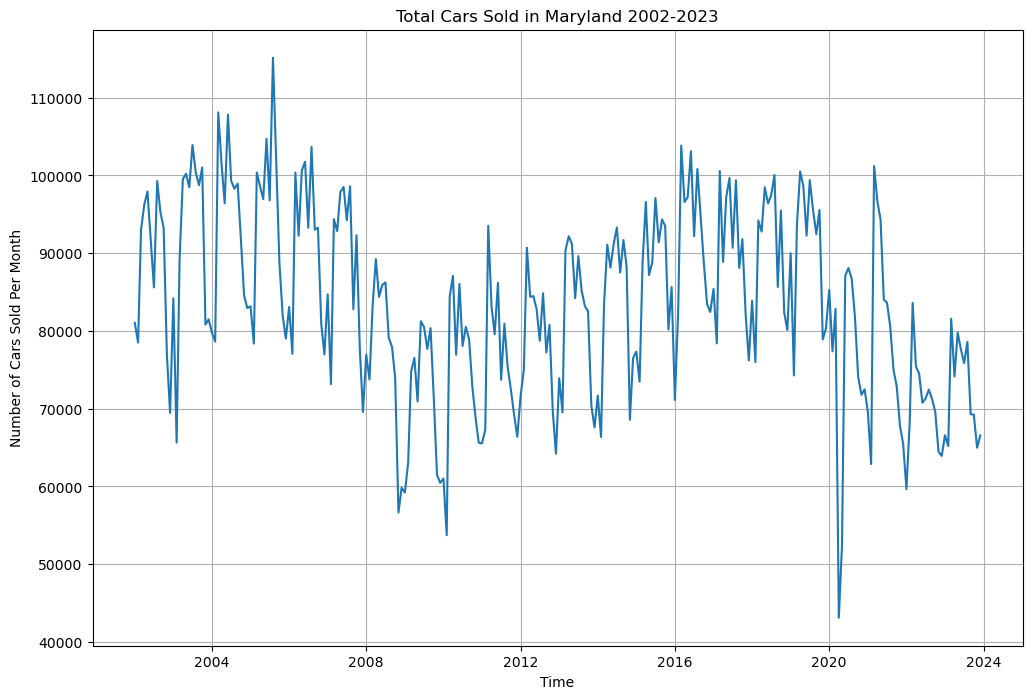

In [18]:
# create a line series graph of total cars sold in Maryland
line_series(sales_data['date'],sales_data['total_cars_sold'],
            'Total Cars Sold in Maryland 2002-2023',
            'Time',
            'Number of Cars Sold Per Month',True)

Observations:
- Seasonality: There are months with lower units cars sold which is observe by the sharp dips and following increase within calendar years

- Irregularities: There are massive oscillations that take place following the turn of 2020 and around 2006.

- Cyclical: There are periods of downturns and recoveries

- Trend: There does not seem to be any clear line trend in the data

#### Seasonality of Total Cars Sold
The first component of total cars sold is the seasonality. Seasonality is understood by looking at the average number of cars sold per month. This helps to break down changes within data that happened on recurring time periods such as a yearly seasonality. It is also will be an important aspect to understand when forecasting sales. This should be the first step as it takes away a lot of the noise that takes place throughout the year and tries to focus on the overall movement of data instead.

In [19]:
# get the monthly mean values of cars sold
monthly_sales_data = create_monthly_data(sales_data,'total_cars_sold',sales_data.index)
monthly_sales_data

,January,February,March,April,May,June,July,August,September,October,November,December
0,81033,78502,93019,96269,97936,91763,85602,99275,95225,93296,76878,69455
1,84188,65633,89218,99538,100214,98477,103899,100385,98743,101014,80810,81491
2,79788,78622,108106,101537,96408,107831,99323,98281,98950,91885,84513,82941
3,83171,78373,100365,98586,96956,104695,96794,115136,101850,88759,81968,79016
4,83076,77060,100372,92247,100611,101757,93273,103667,93018,93279,80914,76976
5,84707,73153,94375,92833,97875,98508,94250,98596,82789,92313,77753,69581
6,76929,73756,83096,89237,84374,85912,86243,79121,77957,73943,56645,59831
7,59217,63087,74792,76536,70930,81241,80529,77683,80353,71500,61485,60464
8,61007,53741,84430,87073,76931,86042,78070,80517,78891,72914,68826,65625
9,65531,67327,93524,83166,79599,86187,73703,80930,75334,72493,69217,66386


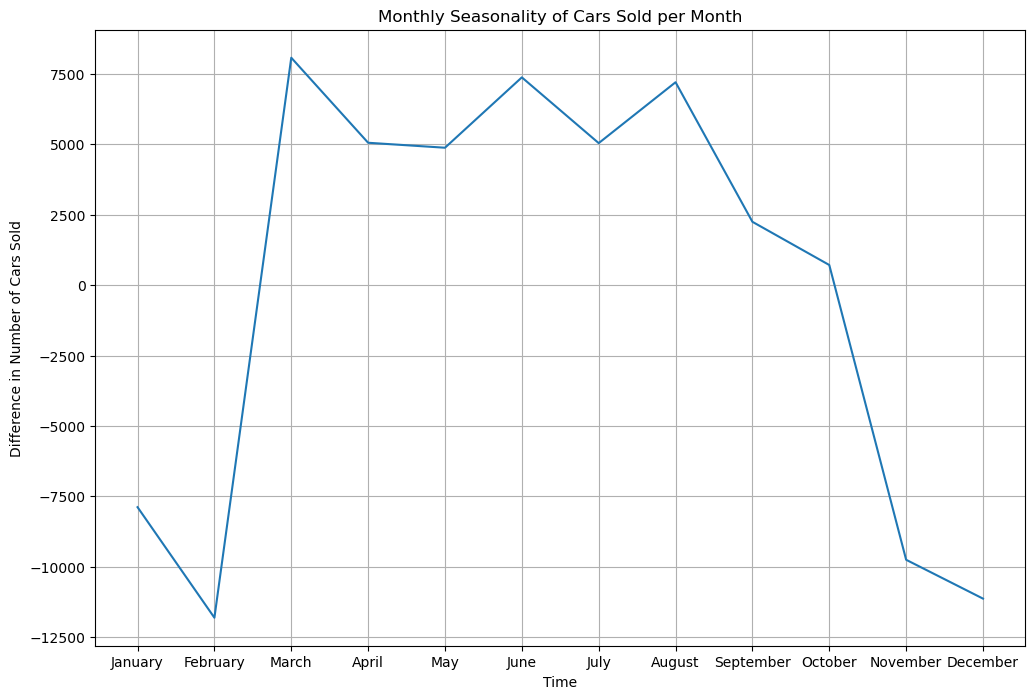

In [20]:
# get the monthly mean of the total cars sold in Maryland
seasonal_monthly = monthly_sales_data.mean()  - sales_data['total_cars_sold'].mean()

line_series(months,seasonal_monthly,'Monthly Seasonality of Cars Sold per Month','Time','Difference in Number of Cars Sold',True)

This visual portrays the following information:

In January, February, November and December (the colder months of the year) there are far less cars sold in these months than the other time periods of the year. This accounts for the large spikes that take place in the original number of cars sold.

In [21]:
# deseasonlise car sales data
# create a copy of original data
sales_data_deseasonlise = sales_data.copy()

# get a copy of datetime
sales_data_deseasonlise['date'] = pd.to_datetime(sales_data_deseasonlise['date'])

# get the month of date
sales_data_deseasonlise['month'] = sales_data['date'].dt.month_name()

sales_data_deseasonlise

,date,total_cars_sold,month
0,2002-01-01,81033,January
1,2002-02-01,78502,February
2,2002-03-01,93019,March
3,2002-04-01,96269,April
4,2002-05-01,97936,May
...,...,...,...
259,2023-08-01,78601,August
260,2023-09-01,69278,September
261,2023-10-01,69248,October
262,2023-11-01,64980,November


In [22]:
# map the seasonal values based on the month
sales_data_deseasonlise['seasonal_values'] = sales_data_deseasonlise['month'].map(seasonal_monthly)

# remove the seasonal values from total cars sold
sales_data_deseasonlise['deseasonlised_cars_sold'] = sales_data_deseasonlise['total_cars_sold'] - sales_data_deseasonlise['seasonal_values']

# drop the month column
sales_data_deseasonlise.drop(columns='month',inplace=True)

sales_data_deseasonlise

,date,total_cars_sold,seasonal_values,deseasonlised_cars_sold
0,2002-01-01,81033,-7884.609848,88917.609848
1,2002-02-01,78502,-11809.382576,90311.382576
2,2002-03-01,93019,8072.071970,84946.928030
3,2002-04-01,96269,5053.026515,91215.973485
4,2002-05-01,97936,4876.617424,93059.382576
...,...,...,...,...
259,2023-08-01,78601,7201.662879,71399.337121
260,2023-09-01,69278,2246.571970,67031.428030
261,2023-10-01,69248,712.981061,68535.018939
262,2023-11-01,64980,-9752.428030,74732.428030


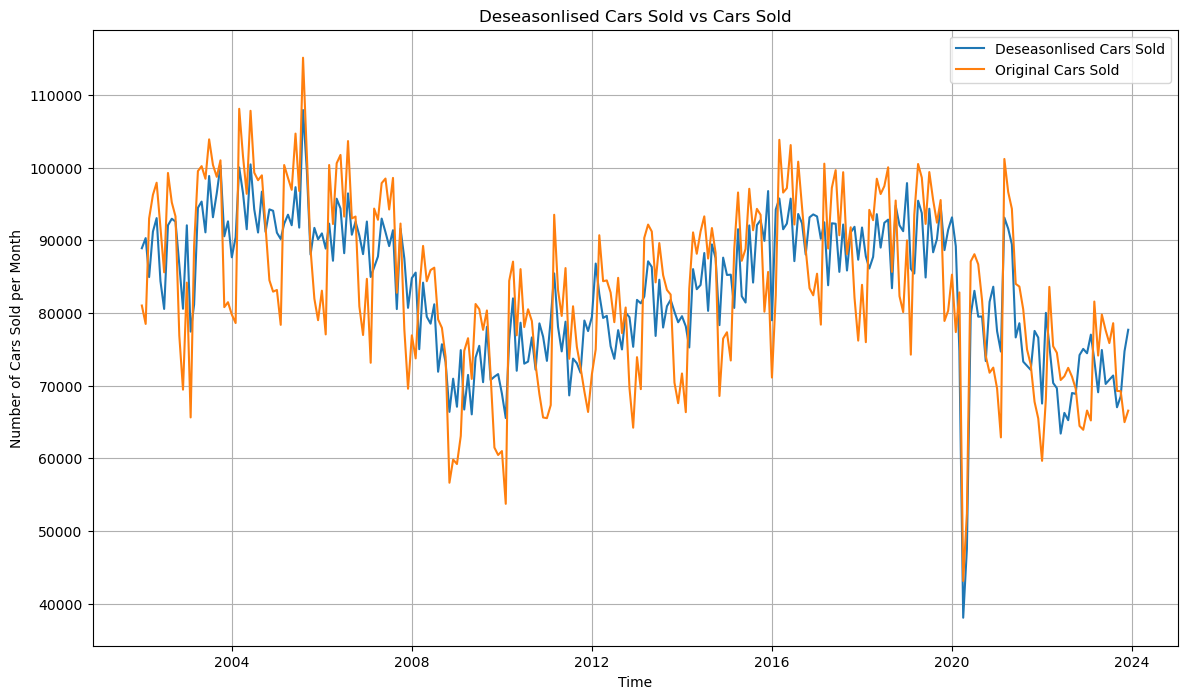

In [23]:
plot_multiple_series(sales_data_deseasonlise['date'],[sales_data_deseasonlise['deseasonlised_cars_sold'],sales_data_deseasonlise['total_cars_sold']],
                     ['Deseasonlised Cars Sold','Original Cars Sold'],'Deseasonlised Cars Sold vs Cars Sold','Time','Number of Cars Sold per Month')

Deseasonlising the data based on the number of cars sold per month is a good start, however further improvement can be made. This is going to be done by looking at the irregularities and if they can be removed, observe how this changes the seasonal values per month.

#### Irregularities in Total Cars Sold
Removing the irregularities in cars sold is going to help improve forecasting. Removing irregularities is going to help generalise the data. However, it is important to understand why the irregularities took place, which will need further investigation into. This will also further improve understanding seasonality.

##### Calculate zscores
zscores represent how many standard deviations away from the mean the value is. The higher the zscore the less expected the value is. As there is no apparent trend for first observation, the zscores are not expected to have a trend as time goes on.

In [24]:
# calculate mean and standard deviation
original_cars_sold_mean = monthly_sales_data.mean() # creates the mean for each month of year 
original_cars_sold_std = monthly_sales_data.std() # creates the std for each month of year

# z-score normalisation
zscore = (monthly_sales_data-original_cars_sold_mean)/original_cars_sold_std

# display the zscore dataframe
zscore

,January,February,March,April,May,June,July,August,September,October,November,December
0,0.579946,0.968067,0.164563,0.593972,0.779738,0.087924,-0.325599,0.777937,0.983196,0.873445,0.382231,-0.372733
1,0.9211,-0.875622,-0.284574,0.8474,0.96661,0.795587,1.665175,0.879298,1.350218,1.620085,0.870801,1.138864
2,0.445323,0.985259,1.947288,1.002371,0.654391,1.781509,1.167291,0.687168,1.371814,0.736944,1.330918,1.320968
3,0.811131,0.949586,1.032589,0.773596,0.699346,1.450971,0.892127,2.226313,1.674362,0.434535,1.014689,0.828029
4,0.800858,0.761478,1.033416,0.282168,0.999178,1.141303,0.509031,1.179,0.752946,0.8718,0.883724,0.571827
5,0.97722,0.201738,0.324792,0.327598,0.774734,0.798854,0.615332,0.715932,-0.314214,0.778349,0.490954,-0.356908
6,0.136176,0.288127,-1.007968,0.048819,-0.332798,-0.528778,-0.255856,-1.062463,-0.818321,-0.998767,-2.13182,-1.581407
7,-1.779042,-1.240377,-1.989193,-0.93582,-1.435655,-1.021107,-0.877558,-1.193777,-0.568354,-1.235103,-1.530426,-1.501909
8,-1.585487,-2.57934,-0.850338,-0.118944,-0.943373,-0.515076,-1.145105,-0.934985,-0.72088,-1.098313,-0.61827,-0.853741
9,-1.096302,-0.632929,0.224236,-0.421832,-0.724508,-0.499793,-1.620249,-0.897271,-1.091971,-1.13904,-0.569686,-0.758167


The dataframe represents the zscore of each value from the 22 years of data based on the monthly mean/std. As there is no trend these values should not show a trend as time continues. Those with very high standard deviations such as greater than 2 are not a part of cyclical or trend changes.

In [25]:
# create a mask for where the zscores is greater than 2
seasonality_zscore = abs(zscore)>=2

zscores greater than 2 will have their values replace with the seasonal value that was calculated from the original seasonality decomposition summed with the yearly mean in the data. This should create a more generalised data value that might be artificial but is going to be beneficial when having a seasonal value that is more accurate overall than being skewed by outliers, such as those with zscores greater than 2.

In [26]:
import math

# create a copy of the original data frame
monthly_sales_data_irregularities_removed = monthly_sales_data.copy()

# create mean data for each year
yearly_mean = monthly_sales_data.mean(axis=1)

# create an array of values
expected_values = []

# iterate over the data where the seasonality z score is true
for index,row in monthly_sales_data_irregularities_removed.iterrows(): # iterate over the rows
    for col in monthly_sales_data_irregularities_removed: # iterate over the columns
            if seasonality_zscore.loc[index,col] == True:
                monthly_sales_data_irregularities_removed.loc[index,col] = math.ceil(seasonal_monthly[col]) + math.ceil(yearly_mean[index]) # mean of year zscore is in
                expected_values.append(seasonal_monthly[col] + yearly_mean[index])
monthly_sales_data_irregularities_removed

,January,February,March,April,May,June,July,August,September,October,November,December
0,81033,78502,93019,96269,97936,91763,85602,99275,95225,93296,76878,69455
1,84188,65633,89218,99538,100214,98477,103899,100385,98743,101014,80810,81491
2,79788,78622,108106,101537,96408,107831,99323,98281,98950,91885,84513,82941
3,83171,78373,100365,98586,96956,104695,96794,101008,101850,88759,81968,79016
4,83076,77060,100372,92247,100611,101757,93273,103667,93018,93279,80914,76976
5,84707,73153,94375,92833,97875,98508,94250,98596,82789,92313,77753,69581
6,76929,73756,83096,89237,84374,85912,86243,79121,77957,73943,67502,59831
7,59217,63087,74792,76536,70930,81241,80529,77683,80353,71500,61485,60464
8,61007,62697,84430,87073,76931,86042,78070,80517,78891,72914,68826,65625
9,65531,67327,93524,83166,79599,86187,73703,80930,75334,72493,69217,66386


In [27]:
import math

# Get the rows and columns where the condition is True
rows, cols = seasonality_zscore.index, seasonality_zscore.columns
true_positions = [
    (row + 2002, col, monthly_sales_data.loc[row, col])
    for row in rows
    for col in cols
    if seasonality_zscore.loc[row, col]
]
# display the positions along with the values
print("True values are at the following positions (row, column, value):")
for id,position in enumerate(true_positions):
        print(f'{position[0]}-{position[1]} | Observed: {position[2]}, Expected: {math.ceil(expected_values[id])}, Difference: {position[2]-math.ceil(expected_values[id])}')

True values are at the following positions (row, column, value):
2005-August | Observed: 115136, Expected: 101008, Difference: 14128
2008-November | Observed: 56645, Expected: 67502, Difference: -10857
2010-February | Observed: 53741, Expected: 62697, Difference: -8956
2020-April | Observed: 43120, Expected: 80309, Difference: -37189
2020-May | Observed: 52407, Expected: 80132, Difference: -27725
2022-June | Observed: 70783, Expected: 77806, Difference: -7023


In [28]:
# convert the monthly wide data to long format 
sales_data_irregularities_removed = convert_to_long_format(monthly_sales_data_irregularities_removed,2002)

# sort by date
sales_data_irregularities_removed.sort_values(by='date',inplace=True)

sales_data_irregularities_removed.rename(columns={'total': 'irregularities_removed_cars_sold'}, inplace=True)

# set index to date
sales_data_irregularities_removed.set_index('date',inplace=True)

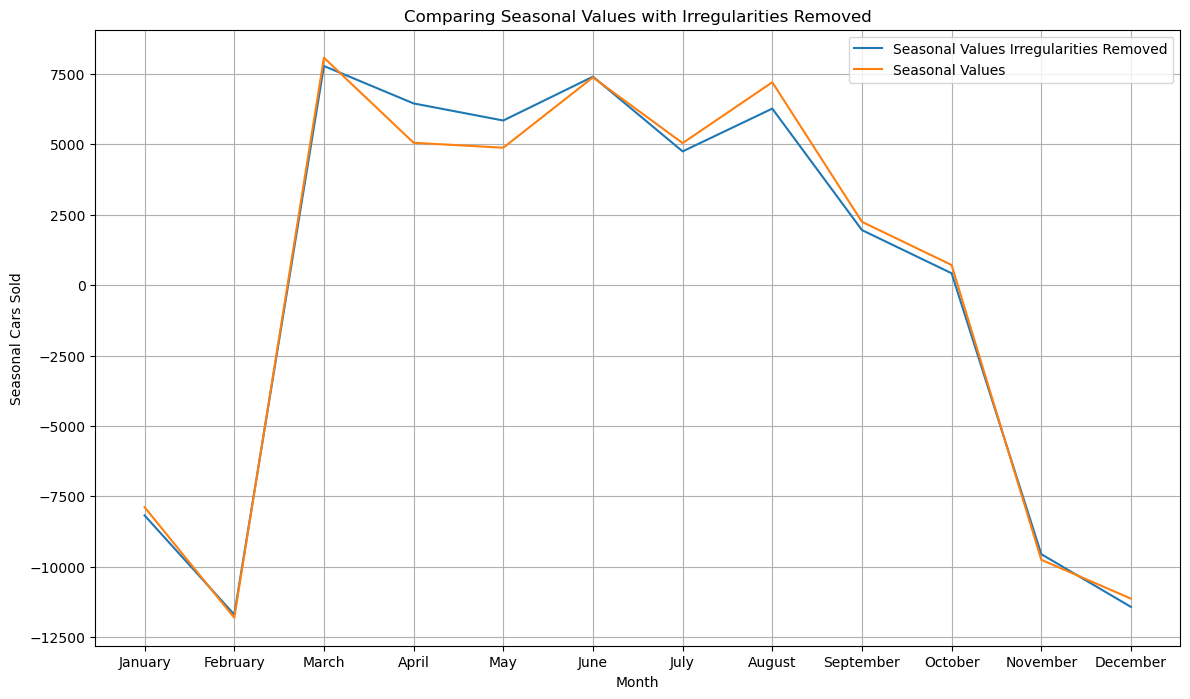

In [29]:
# create new seasonal values with irregularities removed
seasonal_monthly_irregularities_removed = monthly_sales_data_irregularities_removed.mean() - sales_data_irregularities_removed['irregularities_removed_cars_sold'].mean()

plot_multiple_series(months,[seasonal_monthly_irregularities_removed,seasonal_monthly],['Seasonal Values Irregularities Removed','Seasonal Values'],
                     'Comparing Seasonal Values with Irregularities Removed','Month','Seasonal Cars Sold')

The removal and replacement of car sales in the months which are greater than 2 standard deviations of the mean of those months 

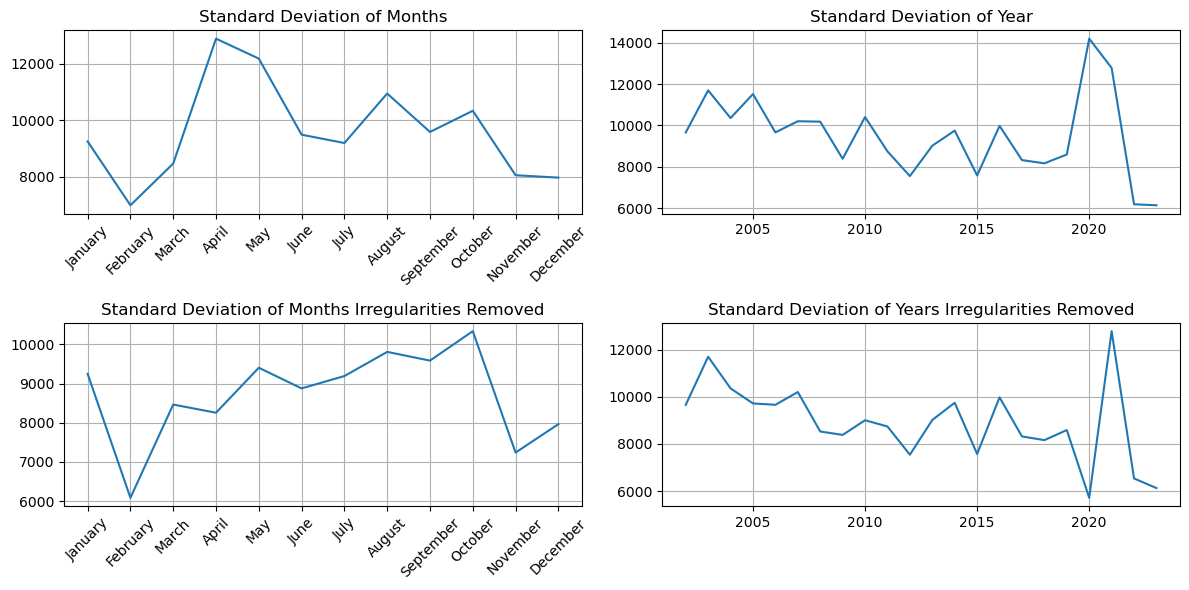

In [30]:
fig,axes = plt.subplots(2,2,figsize=(12,6))

# get the standard deviation of month to month
axes[0,0].plot(months,monthly_sales_data.std(axis=0))
axes[0,0].set_title('Standard Deviation of Months')
axes[0,0].set_xticklabels(months,rotation=45)
axes[0,0].grid()

axes[1,0].plot(months,monthly_sales_data_irregularities_removed.std(axis=0))
axes[1,0].set_title('Standard Deviation of Months Irregularities Removed')
axes[1,0].set_xticklabels(months,rotation=45)
axes[1,0].grid()

# get the standard deviation from year to year
axes[0,1].plot(np.arange(2002,2024), monthly_sales_data.std(axis=1))
axes[0,1].set_title('Standard Deviation of Year')
axes[0,1].grid()

axes[1,1].plot(np.arange(2002,2024),monthly_sales_data_irregularities_removed.std(axis=1))
axes[1,1].set_title('Standard Deviation of Years Irregularities Removed')
axes[1,1].grid()

plt.tight_layout()

The subplot above displays the result of removing the datavalues which had zscores above 2 from their monthly means. The left side shows how the standard deviation has been reduced in months such as April and May which were discovered to have been heavily effected by Covid-19. This can be further seen on the standard deviation in yearly averages as 2021 still has a much higher than average standard deviation. 

In [31]:
# get month name
sales_data_irregularities_removed.reset_index(inplace=True)

# deseasonilise irregularities removed data
sales_data_irregularities_removed_deseasonlised = sales_data_irregularities_removed.copy()

sales_data_irregularities_removed_deseasonlised['month'] = sales_data_irregularities_removed['date'].dt.month_name()

sales_data_irregularities_removed_deseasonlised['seasonal_values'] = sales_data_irregularities_removed_deseasonlised['month'].map(seasonal_monthly_irregularities_removed)

sales_data_irregularities_removed_deseasonlised['irregularities_deseasonlised_cars_sold'] = sales_data_irregularities_removed_deseasonlised['irregularities_removed_cars_sold'] - sales_data_irregularities_removed_deseasonlised['seasonal_values']

sales_data_irregularities_removed_deseasonlised.drop(columns='month',inplace=True)

sales_data_irregularities_removed_deseasonlised

,date,irregularities_removed_cars_sold,seasonal_values,irregularities_deseasonlised_cars_sold
0,2002-01-01,81033,-8178.636364,89211.636364
1,2002-02-01,78502,-11696.318182,90198.318182
2,2002-03-01,93019,7778.045455,85240.954545
3,2002-04-01,96269,6449.409091,89819.590909
4,2002-05-01,97936,5842.818182,92093.181818
...,...,...,...,...
259,2023-08-01,78601,6265.454545,72335.545455
260,2023-09-01,69278,1952.545455,67325.454545
261,2023-10-01,69248,418.954545,68829.045455
262,2023-11-01,64980,-9552.954545,74532.954545


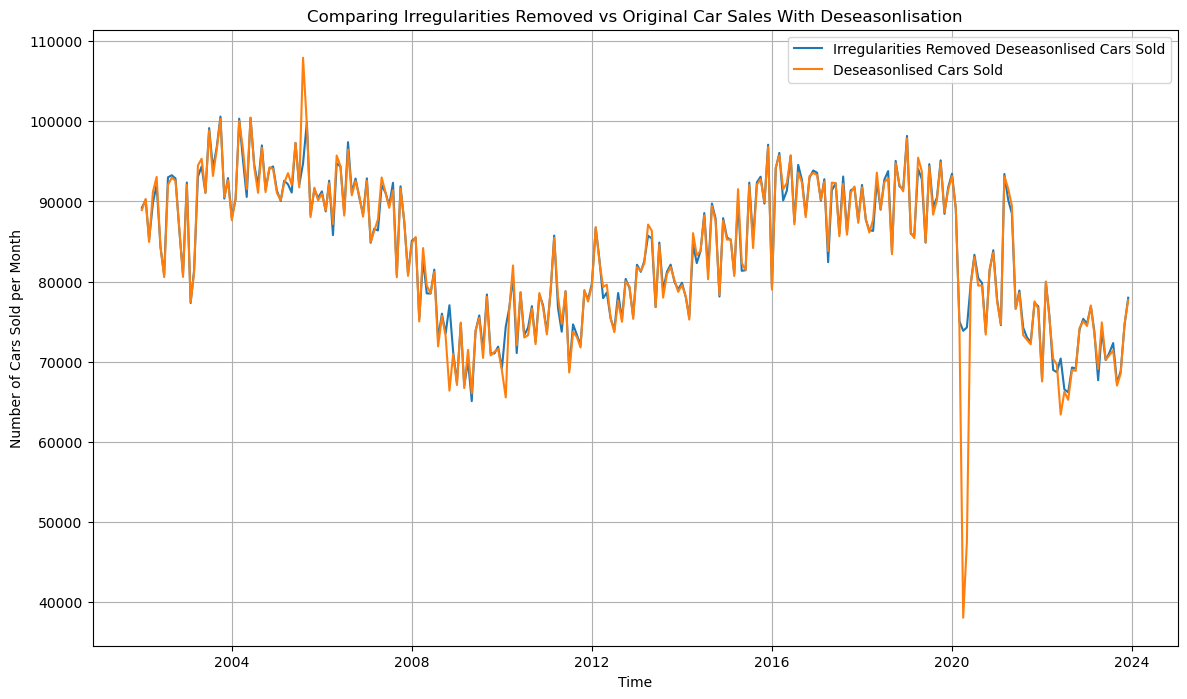

In [32]:
plot_multiple_series(sales_data['date'],
                     [sales_data_irregularities_removed_deseasonlised['irregularities_deseasonlised_cars_sold'],sales_data_deseasonlise['deseasonlised_cars_sold']],
                     ['Irregularities Removed Deseasonlised Cars Sold','Deseasonlised Cars Sold'],
                     'Comparing Irregularities Removed vs Original Car Sales With Deseasonlisation','Time','Number of Cars Sold per Month')

In [33]:
# save the data as deseasonlised data
sales_data_deseasonlise.to_csv('/Users/ben_nicholson/Visual_Code_Projects/Personal_Projects/Maryland Automotive Industry/preprocessed_datasets/car_datasets/deseasonlised_sales_data.csv')

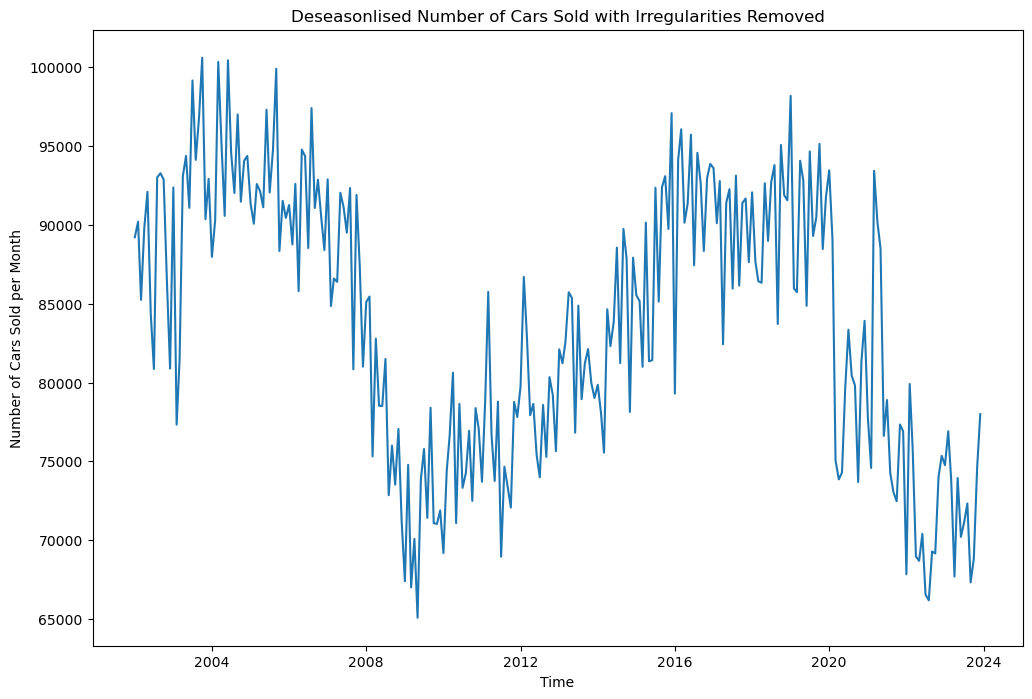

In [34]:
line_series(sales_data_irregularities_removed_deseasonlised['date'],sales_data_irregularities_removed_deseasonlised['irregularities_deseasonlised_cars_sold'],
            'Deseasonlised Number of Cars Sold with Irregularities Removed','Time','Number of Cars Sold per Month')

In [35]:
# find the difference between irregularities and not
irregularities_difference = sales_data['total_cars_sold'] - sales_data_irregularities_removed['irregularities_removed_cars_sold']

In [36]:
sales_data_irregularities_removed_deseasonlised.to_csv('/Users/ben_nicholson/Visual_Code_Projects/Personal_Projects/Maryland Automotive Industry/preprocessed_datasets/car_datasets/irregularities_deseasonlised_sales_data.csv')

#### Cyclical of Total Cars Sold
There seems to be a cyclical nature to the number of cars sold. This is further proven when looking at the deseasonlised data where the irregularities have been removed. As it highlights the remaining cyclical component of the data.

In [37]:
sales_data_irregularities_cylical_removed_deseasonlised = sales_data_irregularities_removed_deseasonlised.copy()
sales_data_irregularities_cylical_removed_deseasonlised

,date,irregularities_removed_cars_sold,seasonal_values,irregularities_deseasonlised_cars_sold
0,2002-01-01,81033,-8178.636364,89211.636364
1,2002-02-01,78502,-11696.318182,90198.318182
2,2002-03-01,93019,7778.045455,85240.954545
3,2002-04-01,96269,6449.409091,89819.590909
4,2002-05-01,97936,5842.818182,92093.181818
...,...,...,...,...
259,2023-08-01,78601,6265.454545,72335.545455
260,2023-09-01,69278,1952.545455,67325.454545
261,2023-10-01,69248,418.954545,68829.045455
262,2023-11-01,64980,-9552.954545,74532.954545


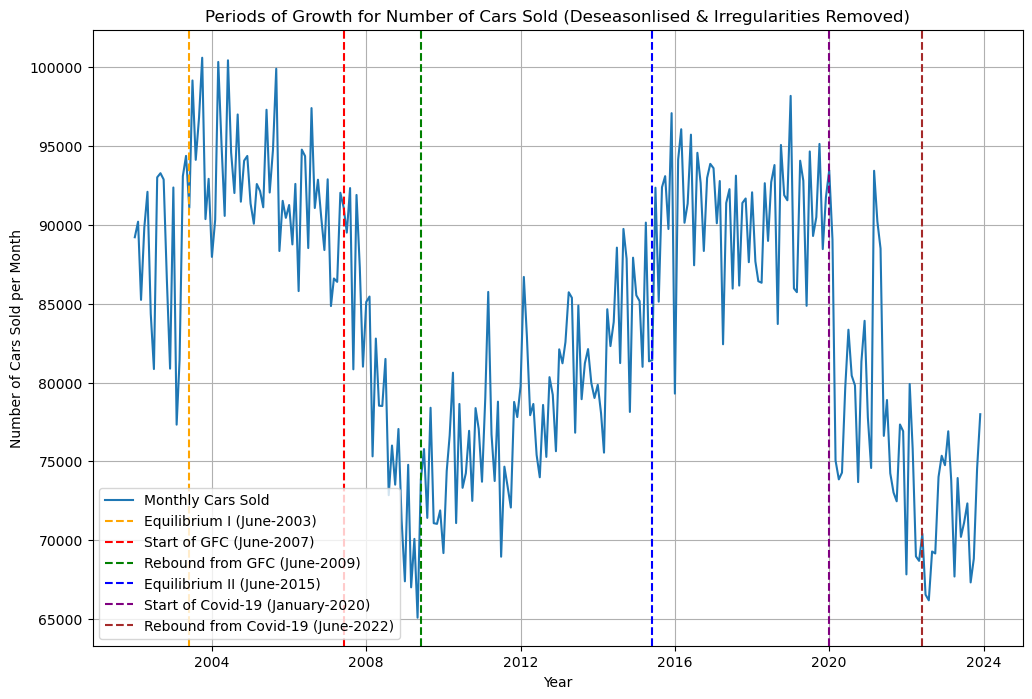

In [38]:
dates = ['2003-06-01','2007-06-01','2009-06-01','2015-06-01','2020-01-01','2022-06-01']
labels = ['Equilibrium I (June-2003)',
          'Start of GFC (June-2007)',
          'Rebound from GFC (June-2009)',
          'Equilibrium II (June-2015)',
          'Start of Covid-19 (January-2020)',
          'Rebound from Covid-19 (June-2022)']
plot_with_annotated_dates(sales_data['date'],sales_data_irregularities_removed_deseasonlised['irregularities_deseasonlised_cars_sold'],
                          labels,dates,'Year','Number of Cars Sold per Month',
                          'Periods of Growth for Number of Cars Sold (Deseasonlised & Irregularities Removed)')

The specific movements have been created based on global events and other periods where the number of cars sold is being changed significantly. These movements will be explored further when looking at chapter 3, in the economic understanding. For now it is going to be assumed that the movement happens on some type of cycle (which is not really the case). These movements can be further observed when smoothing the data.

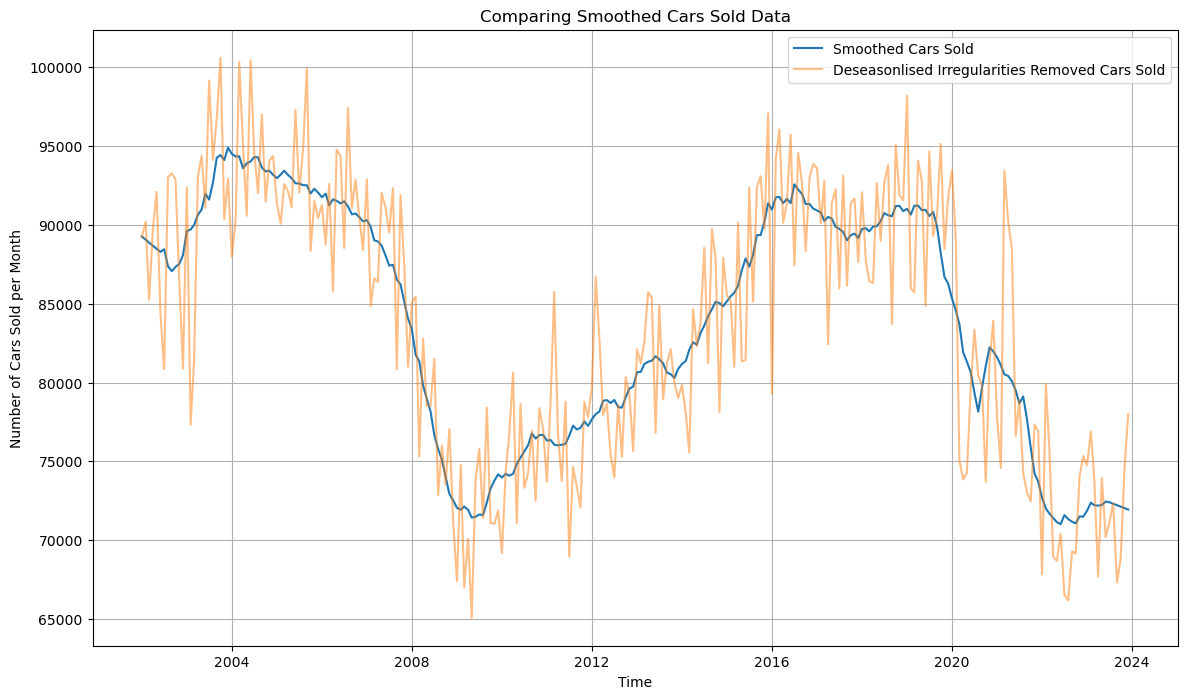

In [39]:
# create yearly smoothed data
smoothed_irregularity_deseasonlised_sales_data = savgol_smooth(sales_data_irregularities_cylical_removed_deseasonlised['irregularities_deseasonlised_cars_sold'],12,1)

plot_multiple_series(sales_data['date'],[smoothed_irregularity_deseasonlised_sales_data,
                      sales_data_irregularities_cylical_removed_deseasonlised['irregularities_deseasonlised_cars_sold']],
                      ['Smoothed Cars Sold','Deseasonlised Irregularities Removed Cars Sold'],'Comparing Smoothed Cars Sold Data','Time',
                      'Number of Cars Sold per Month',alpha=[1,0.5])

There seems to be some type of sinusoidal cycle that takes place. The accerlation of decline after the GFC is faster than Covid-19 but it follows a similar peak and trough. 

The period seems to be about 12 years.

##### Create Sinusoidal Graph
Using the irregularities removed and seasonality removed data, create a sinusoidal graph to reflect the changes that take place within the data.

Sinusoidal graph equations are made up of 
- Amplitude: The vertical distance between the sinusoidal axis (A)
- Period: The time in between two symmetrical points in a sinusoidal wave (T)
- Vertical Translation: Moving the graphs position above or below 0 (D)
- Horizontal Translation: Moving the graphs position to the left or right of 0 (C)
- Frequency: The number of whole cycles that occur within a time period (B)

In [40]:
# sine function
def sine_function(x, A, B, C, D):
    return A * np.sin(B * (x - C)) + D

##### Create Monthly Sinusoidal Graph

In [41]:
A = (smoothed_irregularity_deseasonlised_sales_data.max() - smoothed_irregularity_deseasonlised_sales_data.min()) / 2
D = smoothed_irregularity_deseasonlised_sales_data.mean()
T = 12*12 # this is based off an estimate from examining the smoothed data
B = 2 * np.pi / T

sine_x = np.arange(0,len(sales_data))

sine_y = sine_function(sine_x, A, B, 0, D)

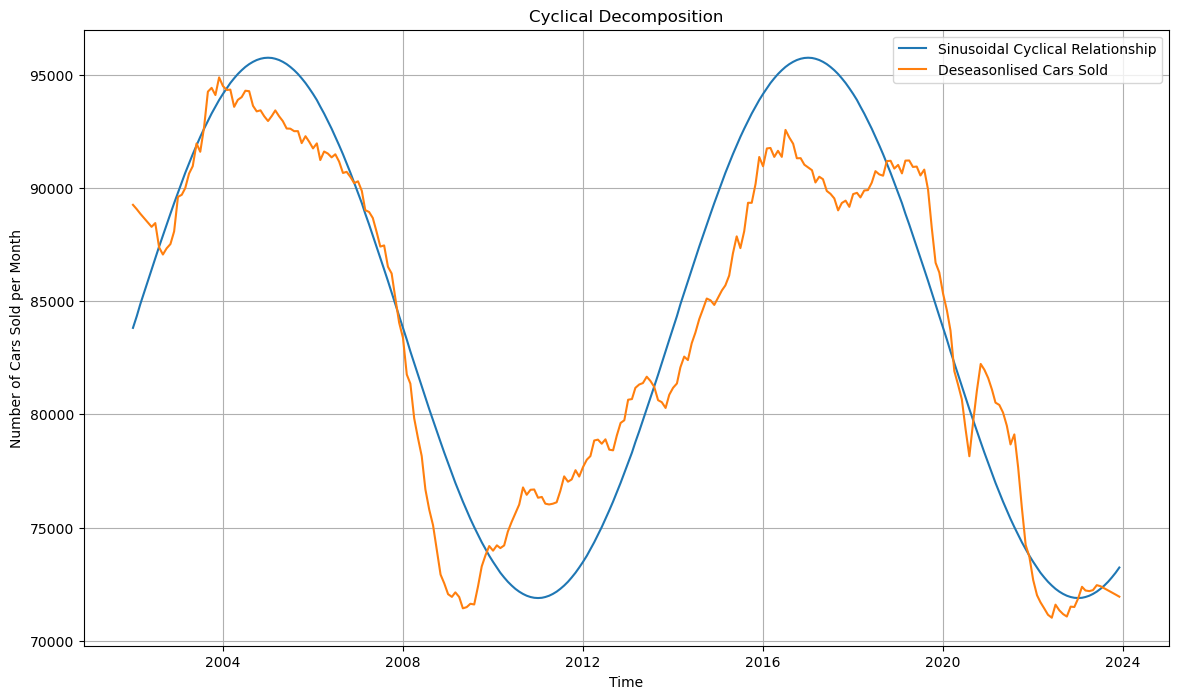

In [42]:
plot_multiple_series(sales_data['date'],[sine_y,smoothed_irregularity_deseasonlised_sales_data],
                     ['Sinusoidal Cyclical Relationship','Deseasonlised Cars Sold']
                     ,'Cyclical Decomposition','Time','Number of Cars Sold per Month')

##### Using Optimisation Techniques to find Cyclical Pattern

In [43]:
popt,pcov = curve_fit(sine_function,sine_x,sine_y,[A,B,0,D])
popt.tolist()

[11934.750000000007, 0.04363323129985824, 0.0, 83820.82502913752]

In [44]:
# compare the difference between manual and automatic creation of sine graph
print(A-popt[0])
print(B-popt[1])
print(0-popt[2])
print(D-popt[3])

0.0
0.0
0.0
0.0


There is no difference which means the manual guesses the ideal parameters for finding the sine graph which best fits the deseasonlised data with irregularities removed.

In [45]:
np.sqrt(np.diag(pcov)).tolist()

[0.0, 0.0, 0.0, 0.0]

There is no error either, this means that the original A,B,C and D values can be used from before.

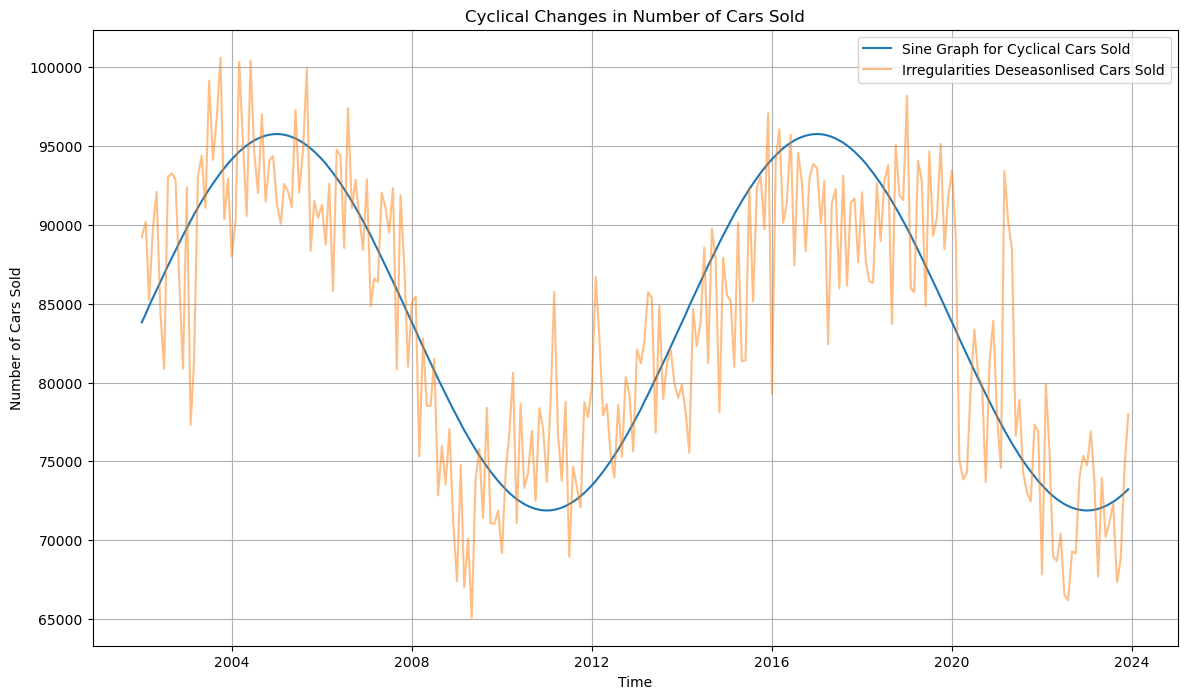

In [46]:
# plot the sine graph against the irregularities removed deseasonlised data
plot_multiple_series(sales_data['date'],[sine_y,sales_data_irregularities_cylical_removed_deseasonlised['irregularities_deseasonlised_cars_sold']],
                     ['Sine Graph for Cyclical Cars Sold','Irregularities Deseasonlised Cars Sold'],
                     'Cyclical Changes in Number of Cars Sold','Time','Number of Cars Sold',[1,0.5])

In [47]:
# create the isolated cyclical sinusoidal graph
sales_data_irregularities_cylical_removed_deseasonlised['cyclical_component'] = sine_y - sine_y.mean()
sales_data_irregularities_cylical_removed_deseasonlised['irregularities_deseasonlised_cyclical_cars_sold'] = sales_data_irregularities_cylical_removed_deseasonlised['irregularities_deseasonlised_cars_sold']- sales_data_irregularities_cylical_removed_deseasonlised['cyclical_component']

In [48]:
# create the vertical shift (average) of results
sales_data_irregularities_cylical_removed_deseasonlised['average'] = sales_data_irregularities_cylical_removed_deseasonlised['irregularities_deseasonlised_cyclical_cars_sold'].mean()

# fully decompose the data
sales_data_irregularities_cylical_removed_deseasonlised['seasonally_decomposed_data'] = sales_data_irregularities_cylical_removed_deseasonlised['irregularities_deseasonlised_cyclical_cars_sold'] - sales_data_irregularities_cylical_removed_deseasonlised['average']

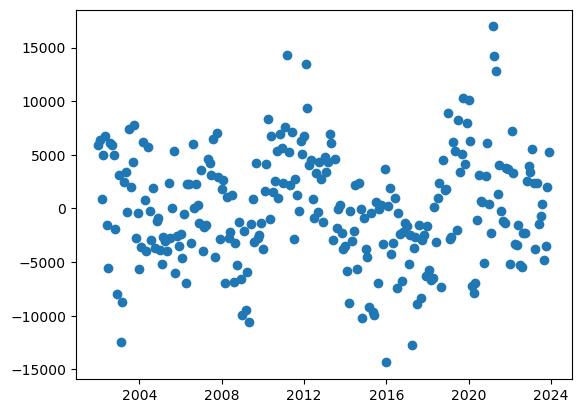

In [49]:
# plot the seasonally decomposed data
plt.scatter(sales_data['date'],sales_data_irregularities_cylical_removed_deseasonlised['seasonally_decomposed_data'])

#### Trend of Seasonally Decomposed Data
The last component to look at is the trend of the data. If there is no trend then check for stationarity of the data, this is done with an ADF test.

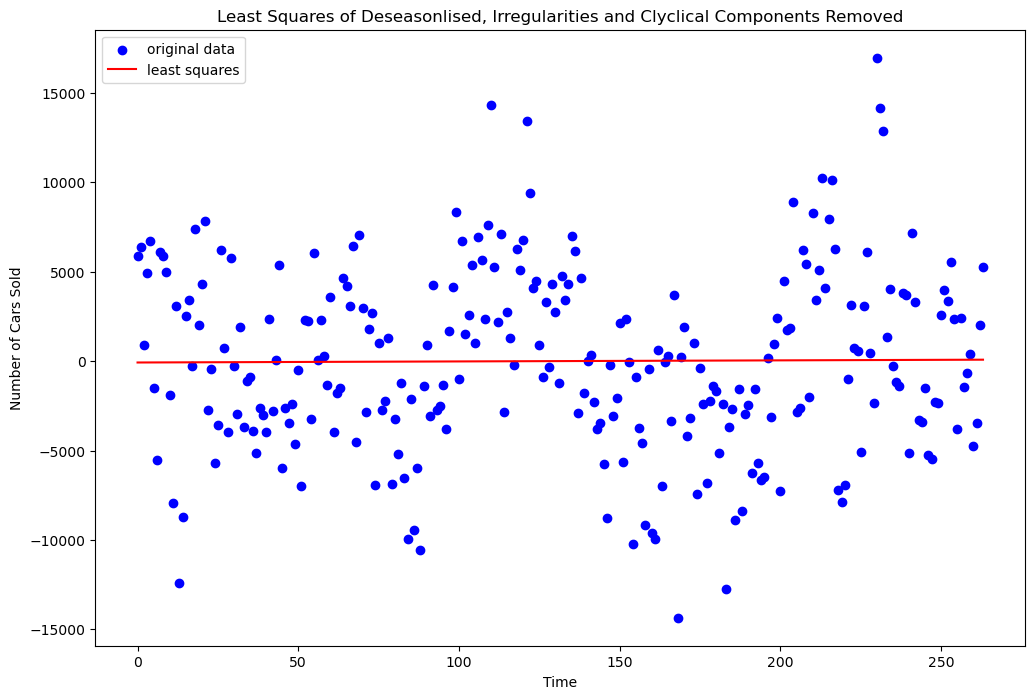

(0.5972560445925656, -78.5391698639398)

In [50]:
least_squares_line(sales_data.index,sales_data_irregularities_cylical_removed_deseasonlised['seasonally_decomposed_data'],'Least Squares of Deseasonlised, Irregularities and Clyclical Components Removed',
                   'Time','Number of Cars Sold')

There is no trend in the data

In [51]:
# adf test for stationarity
adf_test(sales_data_irregularities_cylical_removed_deseasonlised['seasonally_decomposed_data'])

ADF Statistic:  -2.9691299359243004
P-Value:  0.037879580908220016
Critical Value: 
	1%: -3.46
	5%: -2.87
	10%: -2.57


The ADF test suggests stationarity above a theshold of 95% which means that the data passes the stationarity test. 

#### Evaluation of Seasonal Decomposition
The data has been made up of a trend, seasonality component, cyclical component and an average number of cars solds.

By summing these values you get the original data

In [52]:
# create dataframe
seasonal_decomposition_components = pd.DataFrame()

# seasonal component 
seasonal_decomposition_components['seasonal_component'] = sales_data_irregularities_removed_deseasonlised['seasonal_values']

# cyclical component
seasonal_decomposition_components['cyclical_component'] = sales_data_irregularities_cylical_removed_deseasonlised['cyclical_component']

# average (stationary value)
seasonal_decomposition_components['average'] = sales_data_irregularities_cylical_removed_deseasonlised['average']

# add the components up 
seasonal_decomposition_components['calculated_cars_sold'] = seasonal_decomposition_components['seasonal_component'] + seasonal_decomposition_components['cyclical_component'] + seasonal_decomposition_components['average']

seasonal_decomposition_components

,seasonal_component,cyclical_component,average,calculated_cars_sold
0,-8178.636364,-537.531669,83848.272727,75132.104695
1,-11696.318182,-16.945185,83848.272727,72135.009360
2,7778.045455,502.650332,83848.272727,92128.968514
3,6449.409091,1020.265804,83848.272727,91317.947622
4,5842.818182,1534.915920,83848.272727,91226.006829
...,...,...,...,...
259,6265.454545,-11919.905047,83848.272727,78193.822226
260,1952.545455,-11752.528175,83848.272727,74048.290007
261,418.954545,-11563.802919,83848.272727,72703.424353
262,-9552.954545,-11354.088530,83848.272727,62941.229652


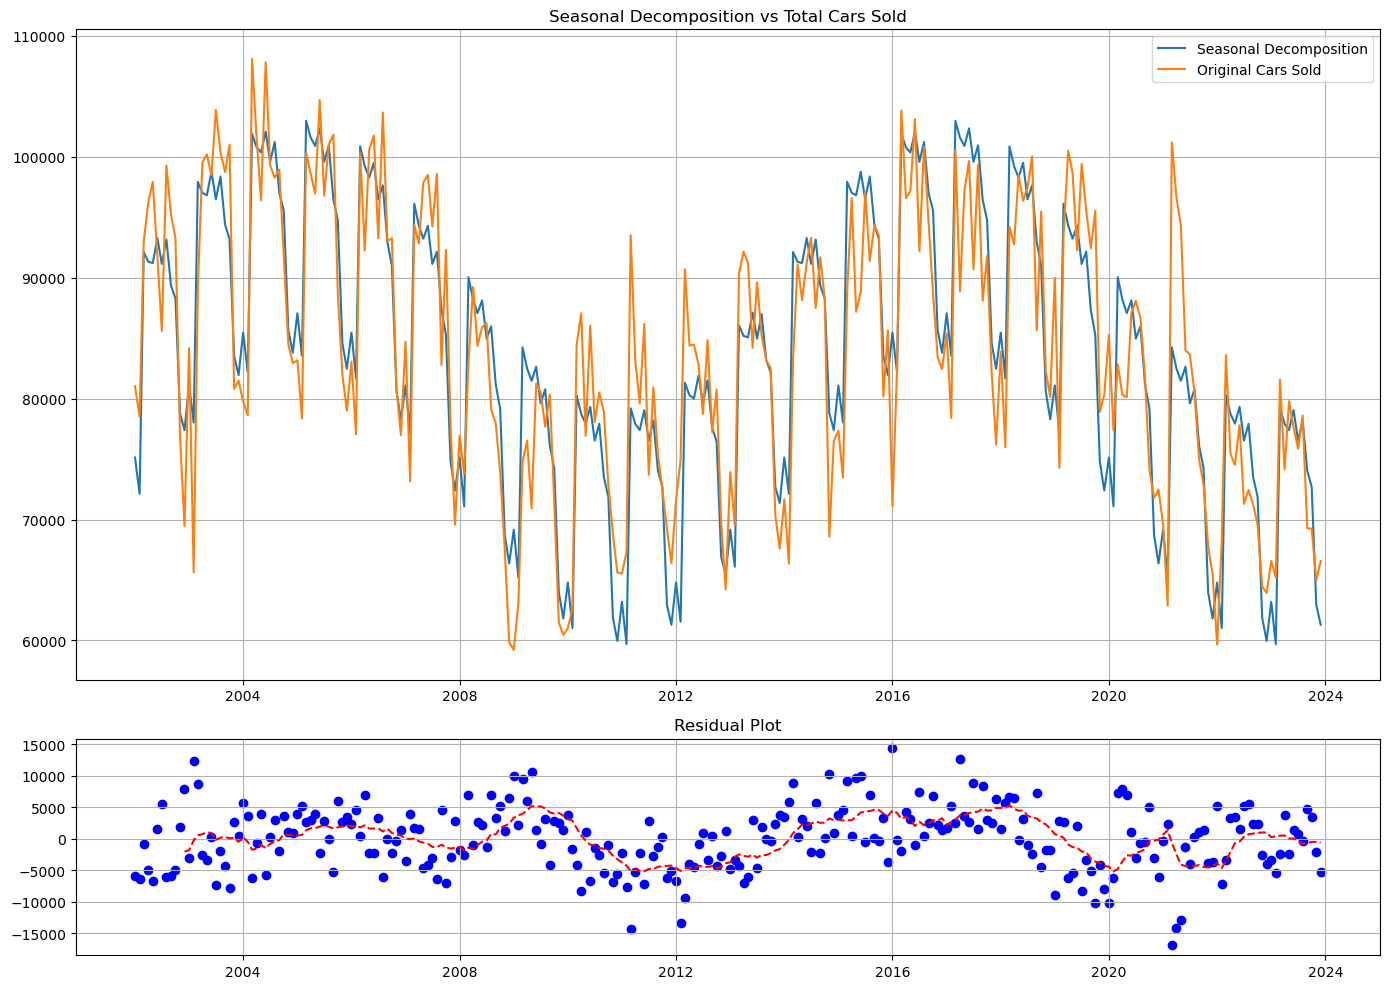

mean absolute error: 4087.311265449298


In [53]:
# create a residual plot of calculated and original number of cars sold
residual = seasonal_decomposition_components['calculated_cars_sold'] - sales_data_irregularities_removed['irregularities_removed_cars_sold']

fig = plt.figure(figsize=(14, 10))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])  # Define the grid layout

# Create subplots with the defined grid
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

# Plot the standard deviation of month to month
ax0.plot(sales_data['date'], seasonal_decomposition_components['calculated_cars_sold'],label='Seasonal Decomposition')
ax0.plot(sales_data['date'], sales_data_irregularities_removed['irregularities_removed_cars_sold'],label='Original Cars Sold')
ax0.set_title('Seasonal Decomposition vs Total Cars Sold')
ax0.grid()
ax0.legend()

# Plot the standard deviation from year to year
ax1.scatter(sales_data['date'], residual,color='blue')
ax1.set_title('Residual Plot')
ax1.grid()

ax1.plot(sales_data['date'],residual.rolling(12).mean(),color='red',linestyle='--')

plt.tight_layout()
plt.show()

print('mean absolute error:',mean_absolute_error(seasonal_decomposition_components['calculated_cars_sold'],sales_data_irregularities_removed['irregularities_removed_cars_sold']))

In [54]:
seasonal_decomposition_components.to_csv('/Users/ben_nicholson/Visual_Code_Projects/Personal_Projects/Maryland Automotive Industry/preprocessed_datasets/car_datasets/components_removed_sales_data.csv')

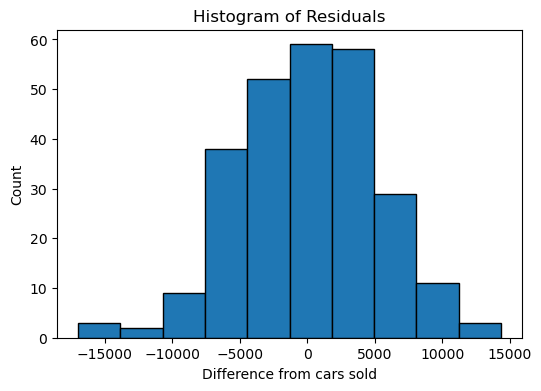

In [55]:
fig, ax = plt.subplots(figsize=(6, 4))
plot_histogram(ax,residual,10,'Histogram of Residuals','Difference from cars sold','Count')

The histogram for the residual values comparing irregularities removed from calculated cars sold displays a normal distribution. This alongside a low p value suggests that the data is stationary which is what is neccessary for successful seasonal decomposition. 

#### Forecast Future Number of Cars Sold

In [56]:
# add future row values from 2024-01-01 to 2040-01-01
forecast = pd.DataFrame()
forecast['date'] = pd.date_range(start='2002-01-01',end='2040-01-01',freq='M')
forecast['total_cars_sold'] = sales_data['total_cars_sold']
forecast

,date,total_cars_sold
0,2002-01-31,81033.0
1,2002-02-28,78502.0
2,2002-03-31,93019.0
3,2002-04-30,96269.0
4,2002-05-31,97936.0
...,...,...
451,2039-08-31,NaN
452,2039-09-30,NaN
453,2039-10-31,NaN
454,2039-11-30,NaN


In [57]:
# create seasonality for each month
forecast['month'] = forecast['date'].dt.month_name()
forecast['seasonality'] = forecast['month'].map(seasonal_monthly_irregularities_removed)

In [58]:
# create cyclical component for each month
x_values_forecast = np.arange(0,len(forecast))

forecast['cyclical'] = sine_function(x_values_forecast,A,B,0,D) - sales_data['total_cars_sold'].mean()

In [59]:
# create an average for each month
forecast['average'] = sales_data['total_cars_sold'].mean()

# create single column
forecast['forecast'] = forecast['average'] + forecast['cyclical'] + forecast['seasonality']
forecast

,date,total_cars_sold,month,seasonality,cyclical,average,forecast
0,2002-01-31,81033.0,January,-8178.636364,266.578817,83554.246212,75642.188666
1,2002-02-28,78502.0,February,-11696.318182,787.165300,83554.246212,72645.093331
2,2002-03-31,93019.0,March,7778.045455,1306.760818,83554.246212,92639.052484
3,2002-04-30,96269.0,April,6449.409091,1824.376290,83554.246212,91828.031593
4,2002-05-31,97936.0,May,5842.818182,2339.026405,83554.246212,91736.090799
...,...,...,...,...,...,...,...
451,2039-08-31,NaN,August,6265.454545,9065.799513,83554.246212,98885.500270
452,2039-09-30,NaN,September,1952.545455,9409.127735,83554.246212,94915.919401
453,2039-10-31,NaN,October,418.954545,9735.052595,83554.246212,93708.253353
454,2039-11-30,NaN,November,-9552.954545,10042.953678,83554.246212,84044.245344


In [60]:
# convert forecast to be only the new data
forecast['forecast'].iloc[0:264] = 0

# create future sales which has existing data with the forecast
forecast['future sales'] = forecast['forecast']+forecast['total_cars_sold'].replace(np.nan,0)

forecast.drop(columns='month',inplace=True)

forecast

/var/folders/6q/lw13gkln44z1r6ncfrmcbc5w0000gn/T/ipykernel_29620/1877741505.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast['forecast'].iloc[0:264] = 0


,date,total_cars_sold,seasonality,cyclical,average,forecast,future sales
0,2002-01-31,81033.0,-8178.636364,266.578817,83554.246212,0.000000,81033.000000
1,2002-02-28,78502.0,-11696.318182,787.165300,83554.246212,0.000000,78502.000000
2,2002-03-31,93019.0,7778.045455,1306.760818,83554.246212,0.000000,93019.000000
3,2002-04-30,96269.0,6449.409091,1824.376290,83554.246212,0.000000,96269.000000
4,2002-05-31,97936.0,5842.818182,2339.026405,83554.246212,0.000000,97936.000000
...,...,...,...,...,...,...,...
451,2039-08-31,NaN,6265.454545,9065.799513,83554.246212,98885.500270,98885.500270
452,2039-09-30,NaN,1952.545455,9409.127735,83554.246212,94915.919401,94915.919401
453,2039-10-31,NaN,418.954545,9735.052595,83554.246212,93708.253353,93708.253353
454,2039-11-30,NaN,-9552.954545,10042.953678,83554.246212,84044.245344,84044.245344


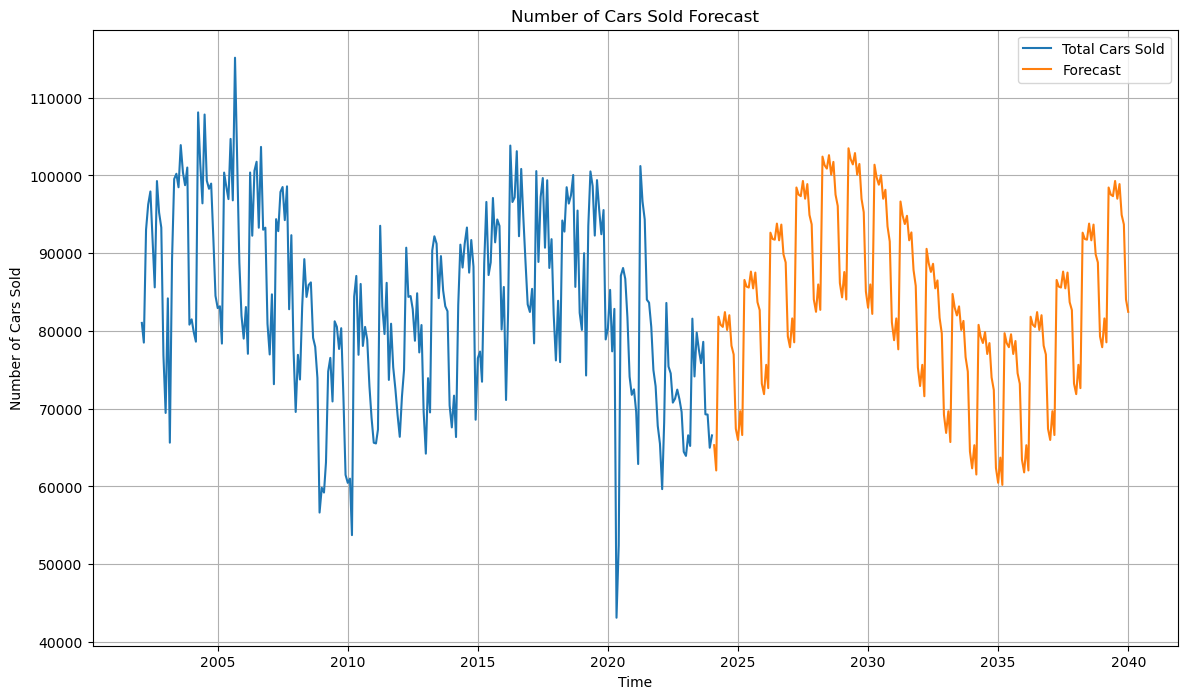

In [61]:
# plot the forecasted data and the number of cars sold
plot_multiple_series(forecast['date'],[forecast['total_cars_sold'],forecast['forecast'].replace(0,np.nan)],
                     ['Total Cars Sold','Forecast'],'Number of Cars Sold Forecast','Time','Number of Cars Sold')

##### Prediction & Confidence Intervals
The prediction interval is the range in which a single response in the future will fall, where as the confidence interval is a range which in which the mean of many different values will fall between. The probability for both of these means that in a 100 future projections 95 fall within the range would represent a 95% confidence/prediction interval.

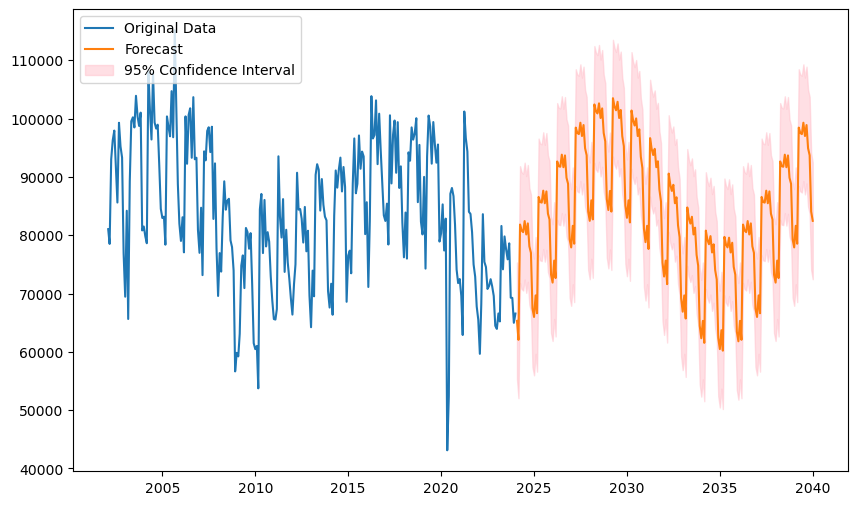

In [62]:
# get the standard error from the resiudal
std_error_residual = residual.std()

# choose the confidence level
confidence_level = 0.95

# get the z_score
z_score = norm.ppf((1 + confidence_level) / 2)

# get the upper and lower bound for forecasting future sales
lower_bound = forecast['forecast'].replace(0,np.nan) - z_score * std_error_residual
upper_bound = forecast['forecast'].replace(0,np.nan) + z_score * std_error_residual

plt.figure(figsize=(10, 6))
plt.plot(forecast['date'], forecast['total_cars_sold'], label='Original Data')
plt.plot(forecast['date'], forecast['forecast'].replace(0,np.nan), label='Forecast')
plt.fill_between(forecast['date'], lower_bound, upper_bound, color='pink', alpha=0.5, label='95% Confidence Interval')
plt.legend(loc='upper left')
plt.show()

##### Random Error within 95% confidence interval forecast

In [63]:
future_sales = forecast[['date','forecast']].iloc[264:].copy()
future_sales.reset_index(inplace=True)
future_sales.drop(columns='index',inplace=True)

,0,1,2,date
0,69940.187148,61655.465204,60634.570346,2024-01-31
1,70193.785321,61374.498593,72824.033620,2024-02-29
2,86938.877024,68313.454623,82070.235217,2024-03-31
3,81519.117437,74271.215878,88372.337574,2024-04-30
4,78236.226577,74238.892352,84813.991283,2024-05-31
...,...,...,...,...
186,95038.567331,106228.062315,97908.879997,2039-07-31
187,99097.489154,108240.966292,102964.732217,2039-08-31
188,94370.301995,97668.489287,89323.858420,2039-09-30
189,88501.110703,86013.490829,100443.031643,2039-10-31


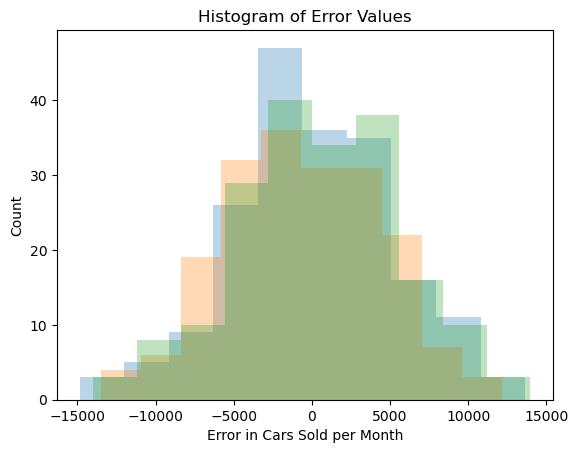

In [64]:
# Calculate necessary parameters from residual
mean_residual = residual.mean()
std_residual = residual.std()
min_residual = residual.min()
max_residual = residual.max()

# Number of future periods (in months) for the forecast
future_sales_length = 192

# Generate random errors and store in DataFrame
random_errors = pd.DataFrame()
for i in range(3):
    random_error = pd.Series(generate_numbers_from_distribution('normal',(0,std_residual),192,min_residual,max_residual))
    random_errors[f'{i}'] = random_error

for col in random_errors:
    plt.hist(random_errors[col],alpha=0.3)
    plt.title('Histogram of Error Values')
    plt.xlabel('Error in Cars Sold per Month')
    plt.ylabel('Count')
    random_errors[col] += future_sales['forecast']

random_errors['date'] = future_sales['date'].iloc[0:len(random_errors)]

random_errors

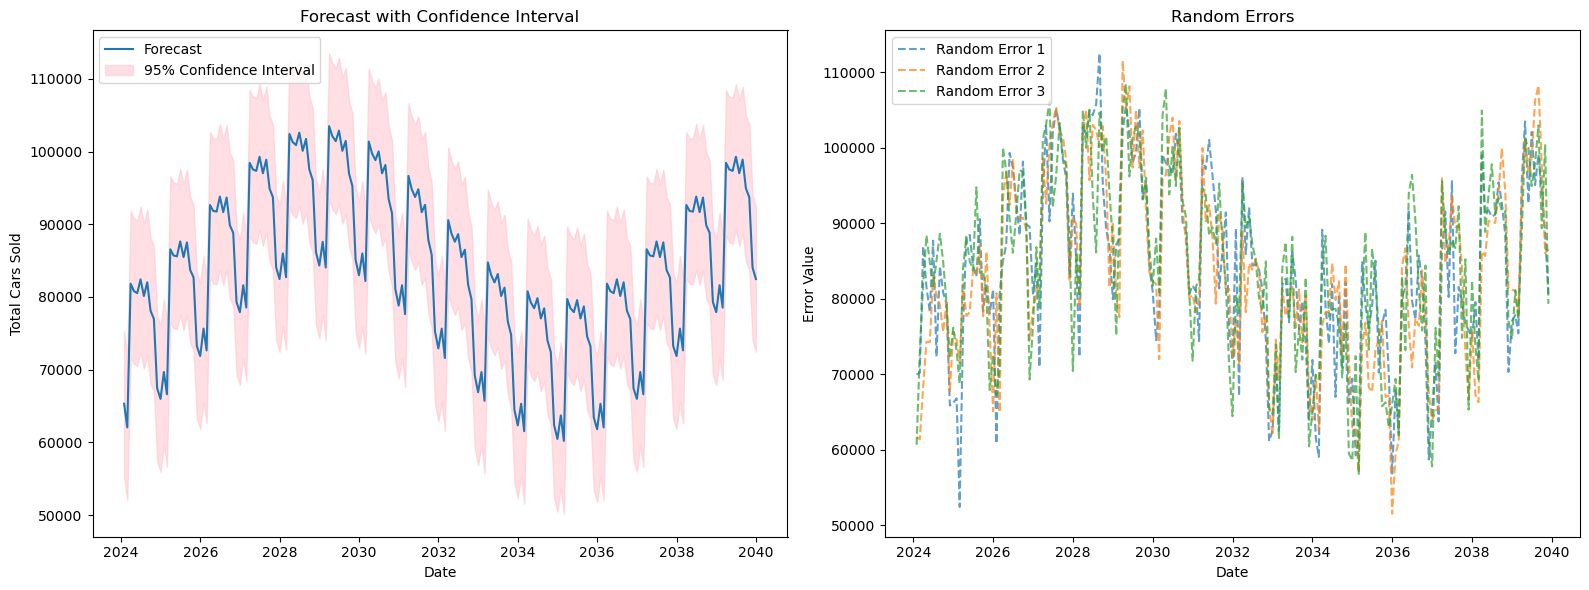

In [65]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming forecast and random_errors dataframes are already defined
# and lower_bound, upper_bound variables are also defined

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# first subplot
ax1.plot(forecast['date'], forecast['forecast'].replace(0, np.nan), label='Forecast')
ax1.fill_between(forecast['date'], lower_bound, upper_bound, color='pink', alpha=0.5, label='95% Confidence Interval')
ax1.legend(loc='upper left')
ax1.set_title('Forecast with Confidence Interval')
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Cars Sold')

# second subplot
ax2.plot(random_errors['date'], random_errors['0'], label='Random Error 1', linestyle='--', alpha=0.7)
ax2.plot(random_errors['date'], random_errors['1'], label='Random Error 2', linestyle='--', alpha=0.7)
ax2.plot(random_errors['date'], random_errors['2'], label='Random Error 3', linestyle='--', alpha=0.7)
ax2.legend(loc='upper left')
ax2.set_title('Random Errors')
ax2.set_xlabel('Date')
ax2.set_ylabel('Error Value')

# adjust layout
plt.tight_layout()
plt.show()

### SARIMA Predictions using Seasonally Decomposed Data
The decomposition of cars sold has seen the data which had cyclical and seasonality removed to be stationary. Use this data to fit ARIMA/SARIMA models to forecast into the future.

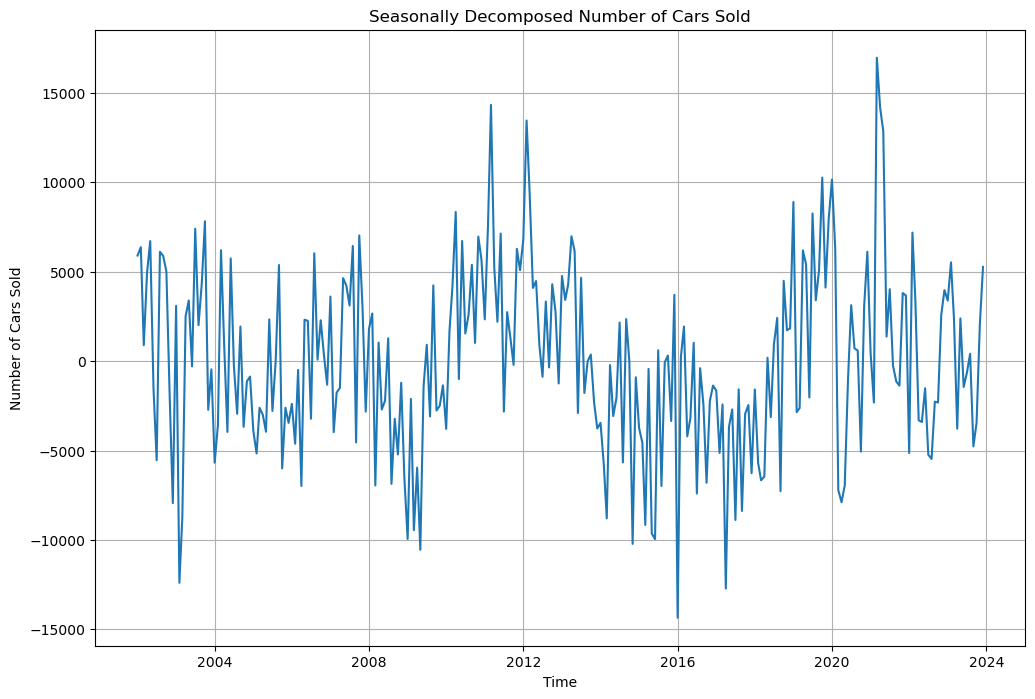

In [66]:
decomposed_data = sales_data_irregularities_cylical_removed_deseasonlised['seasonally_decomposed_data']

line_series(sales_data['date'],decomposed_data,'Seasonally Decomposed Number of Cars Sold','Time','Number of Cars Sold',True)

The graph looks to be quite stationary however there does seem to still have some periods of small fluctuations up and down. Use the ADF test to see if the data is stationary statistically or not.

##### Integrated (I) - d
Look to see if the data rejects the null hypothesis that there is a relationship between time and number of cars sold. If this is not the case then forecasting can be performed.

In [67]:
# look at the ADF test to determine the signifigance level of 
adf_test(decomposed_data)

ADF Statistic:  -2.9691299359243004
P-Value:  0.037879580908220016
Critical Value: 
	1%: -3.46
	5%: -2.87
	10%: -2.57


##### Autoregressive (AR) - p

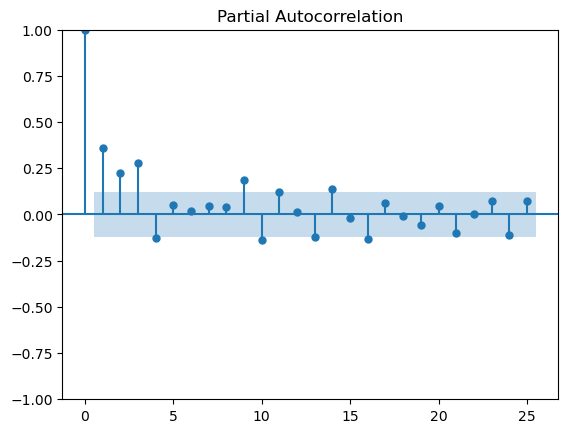

In [68]:
decomposed_pacf = plot_pacf(decomposed_data)

In [69]:
decomposed_p_order = [1,2,3]

##### Moving Average (MA) - q

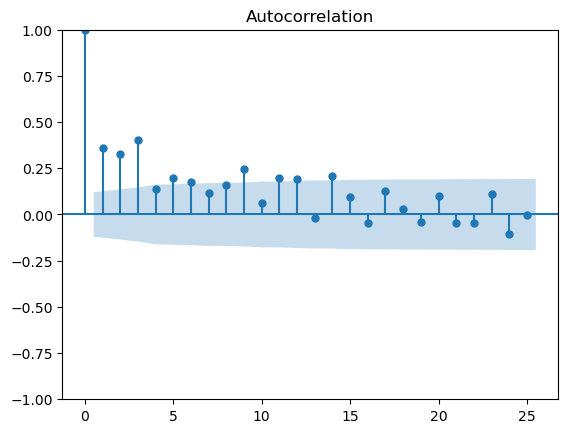

In [70]:
decomposed_acf = plot_acf(decomposed_data)

In [71]:
decomposed_q_order = [1,2,3]

In [72]:
auto_arima(decomposed_data)

ARIMA(order=(3, 0, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [73]:
evaluate_time_series_models(decomposed_data,decomposed_p_order,decomposed_q_order,[0])

,Model,Order,AIC,BIC
